# Notebook: LDA

## 1. Load Packages

In [1]:
from plots import plot_topic_subplots, plot_timeseries_subplots, plot_timeseries_sentiment_subplots
from gensim.models.ldamodel import LdaModel
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from bertopic import BERTopic
from gensim import corpora
import pandas as pd
import numpy as np
import random
import torch
import nltk 
import re

## 2. Constants / Setup

In [2]:
N_TOPICS = 20

In [3]:
FILTERED_DATASET_MENTIONS_PATH = "../Datasets/filtered_mentions.csv"
FILTERED_DATASET_MENTIONS_IMG_PATH = "../Datasets/img_dataset_mentions/images_dataset.csv"
FILTERED_DATASET_POLITICIANS_PATH = "../Datasets/filtered_politicians.csv"
FILTERED_DATASET_POLITICIANS_IMG_PATH = "../Datasets/img_dataset_politicians/images_dataset.csv"

In [4]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

## 3. Load Dataset

In [6]:
df_mentions = pd.read_csv(FILTERED_DATASET_MENTIONS_PATH)
df_mentions

,Unnamed: 0,text,source_party,source_account,date,sentiment,clean_text
0,0,Wichtige wissenschaftliche Erkenntnis- nun mus...,SPD,KarambaDiaby,2021-01-09 19:35:29,0,erkenntnis umsetzung
1,1,@KarambaDiaby @HalleSpd @SPD_LSA Ich gratulier...,SPD,KarambaDiaby,2021-01-09 17:09:28,0,linken
2,2,@KarambaDiaby @HalleSpd @SPD_LSA Herzlichen Gl...,SPD,KarambaDiaby,2021-01-09 13:16:13,0,glückwunsch erfolg
3,3,@KarambaDiaby @HalleSpd @SPD_LSA Wann werden k...,SPD,KarambaDiaby,2021-01-09 12:32:40,1,steuern sozialabgaben rente senkung renteneint...
4,4,@KarambaDiaby @HalleSpd @SPD_LSA Glückwunsch.,SPD,KarambaDiaby,2021-01-09 12:13:06,0,glückwunsch
...,...,...,...,...,...,...,...
707236,707236,@b_riexinger Klima oder Verkehr fast gleich......,LINKE,b_riexinger,2021-12-17 08:19:23,1,klima verkehr pöstchen
707237,707237,@b_riexinger @Linksfraktion Na ob das noch lan...,LINKE,b_riexinger,2021-12-17 08:18:07,1,gruppierungen querdenker linke bürger mitte sy...
707238,707238,@b_riexinger Ich wünsch Dir viel Erfolg.,LINKE,b_riexinger,2021-12-17 07:47:59,0,erfolg
707239,707239,"@b_riexinger Nun, da gibt es ja genügend zu tu...",LINKE,b_riexinger,2021-12-17 02:07:26,2,paris


In [7]:
df_politicians_img = pd.read_csv(FILTERED_DATASET_POLITICIANS_IMG_PATH)
df_politicians_img = df_politicians_img.rename(columns={'extracted_text': 'text'})
df_politicians_img

,Unnamed: 0,tweet_id,image_index,filename,text,url,image_path,source_party,source_account,date
0,0,1377157230630301700,0,1377157230630301700_0.jpg,"Behördenwillkür\n\n\C\n\nD Es wird Zeit, den B...",https://pbs.twimg.com/media/ExylKvEU8AgowSU?fo...,../Datasets/img_dataset_politicians/AFD/AfDBer...,AFD,AfDBerlin,2021-03-31 07:14:04
1,1,1377486425499832320,0,1377486425499832320_0.jpg,NaN,https://pbs.twimg.com/media/Ev5cqNvWgAYX_Fl?fo...,../Datasets/img_dataset_politicians/AFD/AfDBer...,AFD,AfDBerlin,2021-04-01 05:02:10
2,2,1379754099609047040,0,1379754099609047040_0.jpg,IREBSSWEE Folgen\n\n* So geht es nicht weiter!...,https://pbs.twimg.com/media/EyXfBlTWEAEfrHg?fo...,../Datasets/img_dataset_politicians/AFD/AfDBer...,AFD,AfDBerlin,2021-04-07 11:13:06
3,3,1381254353336606721,0,1381254353336606721_0.jpg,6% Die Landesvorsitzende der AfD\nBerlin kriti...,https://pbs.twimg.com/media/EyszgrWXEAEqXID?fo...,../Datasets/img_dataset_politicians/AFD/AfDBer...,AFD,AfDBerlin,2021-04-11 14:34:34
4,4,1381863885666406400,0,1381863885666406400_0.jpg,NaN,https://pbs.twimg.com/media/Ey1d1VqWQAACVNs?fo...,../Datasets/img_dataset_politicians/AFD/AfDBer...,AFD,AfDBerlin,2021-04-13 06:56:38
...,...,...,...,...,...,...,...,...,...,...
21954,21954,1350695518536683524,0,1350695518536683524_0.jpg,Deutsches\nRotes\nKreuz\n\nServiceportal zur I...,https://pbs.twimg.com/media/Er6iaV7XAAIkOIp?fo...,../Datasets/img_dataset_politicians/AFD/Tino_C...,AFD,Tino_Chrupalla,2021-01-17 06:44:40
21955,21955,1351083430218493953,0,1351083430218493953_0.jpg,Deutschland droht der Mega-Lockdown -\n\nobwoh...,https://pbs.twimg.com/media/EsADN8IXAAAnR7o?fo...,../Datasets/img_dataset_politicians/AFD/Tino_C...,AFD,Tino_Chrupalla,2021-01-18 08:26:06
21956,21956,1352556008934137858,0,1352556008934137858_0.jpg,‚ . Die verlorene\nSchülergeneration\n\n,https://pbs.twimg.com/media/EsU-hOsXYAAQyIO?fo...,../Datasets/img_dataset_politicians/AFD/Tino_C...,AFD,Tino_Chrupalla,2021-01-22 09:57:36
21957,21957,1462488643638108170,0,1462488643638108170_0.jpg,zur Impfpflicht! B |\n\nTino Chrupalla Bundess...,https://pbs.twimg.com/media/FEvNqgDWUAUD_5i?fo...,../Datasets/img_dataset_politicians/AFD/Tino_C...,AFD,Tino_Chrupalla,2021-11-21 18:30:39


In [8]:
df_politicians = pd.read_csv(FILTERED_DATASET_POLITICIANS_PATH)
df_politicians

,Unnamed: 0,UserScreenName,source_account,date,Text,text,Emojis,Comments,Likes,Retweets,Image link,Tweet URL,id,source_party,sentiment,clean_text
0,0,AfD Berlin,AfDBerlin,2021-03-26 21:07:22,AfD Berlin\n@AfDBerlin\n·\n26. März,AfD wirkt.\n\nSchluss mit dem #Gendergaga\nMDR...,NaN,4.0,28.0,132.0,['https://pbs.twimg.com/profile_images/1037343...,https://twitter.com/AfDBerlin/status/137555499...,1,AfD,2,afd schluss gendergaga mdr aktuell märz gender...
1,1,AfD Berlin,AfDBerlin,2021-03-27 07:20:27,AfD Berlin\n@AfDBerlin\n·\n27. März,Im Herbst wird gewählt.\nSchluss mit den Recht...,NaN,10.0,20.0,112.0,['https://pbs.twimg.com/card_img/1471780757332...,https://twitter.com/AfDBerlin/status/137570928...,2,AfD,2,herbst schluss rechtsbrüchen regierung bild pr...
2,2,AfD Berlin,AfDBerlin,2021-03-31 07:14:04,AfD Berlin\n@AfDBerlin\n·\n31. März,Behördenwillkür\nFlüchtlingsheime durchgedrück...,NaN,3.0,13.0,34.0,['https://pbs.twimg.com/media/ExylKvEU8AgowSU?...,https://twitter.com/AfDBerlin/status/137715723...,3,AfD,1,behördenwillkür flüchtlingsheime vorwürfen sen...
3,3,AfD Berlin,AfDBerlin,2021-04-01 14:29:00,AfD Berlin\n@AfDBerlin\n·\n1. Apr.,Aus Raider wird jetzt Twix \n\nLeider kein #Ap...,NaN,1.0,4.0,17.0,['https://pbs.twimg.com/card_img/1472910546907...,https://twitter.com/AfDBerlin/status/137762907...,4,AfD,2,raider twix aprilscherz bz berlin name astraze...
4,4,AfD Berlin,AfDBerlin,2021-04-01 05:02:10,AfD Berlin\n@AfDBerlin\n·\n1. Apr.,Gendern geht („*innen“)\nImpfen geht nicht.\nD...,NaN,1.0,3.0,16.0,['https://pbs.twimg.com/profile_images/9706413...,https://twitter.com/AfDBerlin/status/137748642...,5,AfD,1,gendern impfen regierung deutschland welt abwä...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58859,58859,Tino Chrupalla,Tino_Chrupalla,2021-12-04 17:26:46,Tino Chrupalla\n@Tino_Chrupalla\n·\n4. Dez. 2021,Friedlicher Protest gegen einen #Impfzwang ist...,NaN,265.0,122.0,578.0,[],https://twitter.com/Tino_Chrupalla/status/1467...,61802,AfD,1,protest impfzwang grundrecht schutz privatsphä...
58860,58860,Tino Chrupalla,Tino_Chrupalla,2021-12-13 16:30:19,Tino Chrupalla\n@Tino_Chrupalla\n·\n13. Dez. 2021,@OlafScholz\n muss sich endlich klar zu Nord S...,NaN,4.0,2.0,11.0,[],https://twitter.com/Tino_Chrupalla/status/1470...,61803,AfD,0,nord stream interessen energieversorgung
58861,58861,Tino Chrupalla,Tino_Chrupalla,2021-12-17 14:02:24,Tino Chrupalla\n@Tino_Chrupalla\n·\n17. Dez. 2021,Mit \n@_FriedrichMerz\n gibt es keine konserva...,NaN,188.0,227.0,1.008,[],https://twitter.com/Tino_Chrupalla/status/1471...,61804,AfD,1,erneuerung ausgrenzung bürger kälte management...
58862,58862,Tino Chrupalla,Tino_Chrupalla,2021-12-19 09:27:23,Tino Chrupalla\n@Tino_Chrupalla\n·\n19. Dez. 2021,Wir wünschen Ihnen und Ihrer Familie einen bes...,NaN,449.0,346.0,2.648,['https://pbs.twimg.com/media/FG9dwrcXIAUF5BP?...,https://twitter.com/Tino_Chrupalla/status/1472...,61805,AfD,0,familie advent


In [9]:
df_mentions_img = pd.read_csv(FILTERED_DATASET_MENTIONS_IMG_PATH)
df_mentions_img = df_mentions_img.rename(columns={'extracted_text': 'text'})
df_mentions_img

,Unnamed: 0,tweet_id,image_index,filename,text,url,image_path,source_party,source_account,date
0,0,1345866502268985354,0,1345866502268985354_0.jpg,NaN,https://pbs.twimg.com/media/Eq16c2qXYAwa__x.jpg,../Datasets/img_dataset_mentions/CDU_CSU/Armin...,CDU_CSU,ArminLaschet,2021-01-03 22:55:53
1,1,1345863370579320832,0,1345863370579320832_0.jpg,Asyl- |\nmißbrauch\n\n,https://pbs.twimg.com/media/Eq13meUXEAMWanr.jpg,../Datasets/img_dataset_mentions/CDU_CSU/Armin...,CDU_CSU,ArminLaschet,2021-01-03 22:43:27
2,2,1345860999602184196,0,1345860999602184196_0.jpg,"kann, dass dieses '\n\nGesindel\n\nwieder vers...",https://pbs.twimg.com/media/Eq11cdkW8AU8leb.jpg,../Datasets/img_dataset_mentions/CDU_CSU/Armin...,CDU_CSU,ArminLaschet,2021-01-03 22:34:01
3,3,1345841888289550345,0,1345841888289550345_0.jpg,"25. Februar 2011, 11:45 Uhr FDPrudert zurück\n...",https://pbs.twimg.com/media/Eq1kEA2XUAAyW_f.jpg,../Datasets/img_dataset_mentions/CDU_CSU/Armin...,CDU_CSU,ArminLaschet,2021-01-03 21:18:05
4,4,1345840672113373186,0,1345840672113373186_0.jpg,You can fool some of the people all of the tim...,https://pbs.twimg.com/media/Eq1i03_W4AANqWe.png,../Datasets/img_dataset_mentions/CDU_CSU/Armin...,CDU_CSU,ArminLaschet,2021-01-03 21:13:15
...,...,...,...,...,...,...,...,...,...,...
34136,34136,1438112331666530313,1,1438112331666530313_1.jpg,NaN,https://pbs.twimg.com/media/E_UzixMXoAg5Bay.jpg,../Datasets/img_dataset_mentions/LINKE/b_riexi...,LINKE,b_riexinger,2021-09-15 13:07:53
34137,34137,1438111715409936387,0,1438111715409936387_0.jpg,NaN,https://pbs.twimg.com/media/E_Uy-8FWYAUkFY5.jpg,../Datasets/img_dataset_mentions/LINKE/b_riexi...,LINKE,b_riexinger,2021-09-15 13:05:26
34138,34138,1444703262951759880,0,1444703262951759880_0.jpg,Zusammenhalten.\nFür Gerechtigkeit.\nDIE LINKE.\n,https://pbs.twimg.com/media/FAyahiCXoAI6Kzy.jpg,../Datasets/img_dataset_mentions/LINKE/b_riexi...,LINKE,b_riexinger,2021-10-03 17:37:53
34139,34139,1446709991805751297,0,1446709991805751297_0.jpg,Das umgekehrte Bild bei der\n\nLinken: Sie ver...,https://pbs.twimg.com/media/FBO-9t7WEAkN-fA.jpg,../Datasets/img_dataset_mentions/LINKE/b_riexi...,LINKE,b_riexinger,2021-10-09 06:31:55


## 4. Code

#### Clean Data

In [10]:
stopwords = set(stopwords.words("german")).union(set(stopwords.words("english")))
stopwords.update(["ja", "nein", "mal", "nein", "schon", "immer", "utm", "the", "to", "mehr", "com", "geht", "heute", "https", "thread", "anzeigen", "https", "http", "www", "co", "de", "html", "nehmen", "habt", "hast", "tut", "gibt", "wäre", "steht", "ganz", "usw", "ging", "seid", "liegt", "sagen", "finde", "denen", "übrigens", "trotzdem", "darauf", "hätte", "wer", "sogar", "weiß"])

In [11]:
df = df_politicians_img.copy()

In [12]:
df['date'] = pd.to_datetime(df['date'])
months = df['date'].dt.month.to_list()

In [13]:
import math
def remove_stopwords_and_clean(data):
    
    def clean_text(text):
        RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
        RE_TAGS = re.compile(r"<[^>]+>")
        RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)

        text = re.sub(r'@\w+', '', text)
        text = re.sub(RE_TAGS, " ", text)
        text = re.sub(RE_ASCII, " ", text)
        text = re.sub(RE_SINGLECHAR, " ", text)
        text = re.sub(RE_WSPACE, " ", text)
        return text
    
    output_array = []
    for sentence in data:
        if type(sentence) != str:
            sentence = ""
        sentence = clean_text(sentence)
        temp_list = [word for word in sentence.split() if word.lower() not in stopwords]
        output_array.append(' '.join(temp_list))
    
    return output_array

In [14]:
cleaned_text = remove_stopwords_and_clean(df.text.to_list())

#### Train BERTopic

In [15]:
#from sklearn.cluster import KMeans

#cluster_model = KMeans(n_clusters=30)
#model = BERTopic(hdbscan_model=cluster_model)

In [16]:
#from sklearn.cluster import AgglomerativeClustering

#cluster_model = AgglomerativeClustering(n_clusters=30)
#model = BERTopic(hdbscan_model=cluster_model, language="german")

In [17]:
from hdbscan import HDBSCAN

hdbscan_model = HDBSCAN(min_cluster_size=25, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
model = BERTopic(language="german", hdbscan_model=hdbscan_model, nr_topics=31) #, nr_topics=31

In [18]:
topics, probabilities = model.fit_transform(cleaned_text)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [19]:
#topics = model.reduce_outliers(cleaned_text, topics)

In [20]:
model.update_topics(cleaned_text, topics)

In [21]:
topics_over_time = model.topics_over_time(cleaned_text, months)

In [22]:
topics_over_time

,Topic,Words,Frequency,Timestamp
0,-1,"corona, uhr, deutschland, januar, cdu",508,1
1,0,"spd, en, bundestag, dr, afd",1057,1
2,1,"schuldenbremse, prozent, mindestlohn, walsh, s...",19,1
3,2,"cdu, cduzcsu, baukindergeld, csu, cduvorsitz",25,1
4,3,"cases, age, covid, new, confirmed",27,1
...,...,...,...,...
329,21,"alice, weidel, physiknobelpreis, trägerin, curie",3,12
330,26,"app, warn, risiko, corona, verantwortung",3,12
331,27,"görke, nimm, link, linke, en",1,12
332,28,"dietmar, bartsch, linksfraktion, bartsc, frakt...",3,12


In [23]:
n_topics = model.get_topic_freq().shape[0] - 1
document_info = model.get_document_info(cleaned_text)
topics_over_time["Name"] = topics_over_time["Topic"].apply(lambda x: document_info[document_info["Topic"] == x]["Name"].iloc[0])
document_info["date"] = df["date"]
if 'sentiment' in df.columns:
    document_info["sentiment"] = df["sentiment"]
document_info["month"] = df['date'].dt.month

In [24]:
model.get_document_info(cleaned_text)[model.get_document_info(cleaned_text)["Topic"] == -1]

,Document,Topic,Name,Top_n_words,Probability,Representative_document
0,Behördenwillkür Zeit Bürgerwillen erst,-1,-1_deutschland_uhr_afd_corona,deutschland - uhr - afd - corona - en - bundes...,0.0,False
5,Corona Bürgerrechte Bl Keihe Zweiklassengesell...,-1,-1_deutschland_uhr_afd_corona,deutschland - uhr - afd - corona - en - bundes...,0.0,False
7,Mietendeckel Chaos Müllers klägliches Versagen...,-1,-1_deutschland_uhr_afd_corona,deutschland - uhr - afd - corona - en - bundes...,0.0,False
8,Mietendeckel Vs Danke Senat Steuerzahler AD UR...,-1,-1_deutschland_uhr_afd_corona,deutschland - uhr - afd - corona - en - bundes...,0.0,False
9,spiegel deutliche Übersterblichkeit Deutschland,-1,-1_deutschland_uhr_afd_corona,deutschland - uhr - afd - corona - en - bundes...,0.0,False
...,...,...,...,...,...,...
21949,Martin Debes Thüringer Allgemeine Begründung D...,-1,-1_deutschland_uhr_afd_corona,deutschland - uhr - afd - corona - en - bundes...,0.0,False
21950,Zustimmung Mitgliederentscheid rgr Koalitionsv...,-1,-1_deutschland_uhr_afd_corona,deutschland - uhr - afd - corona - en - bundes...,0.0,False
21952,FFP Masken zentral noschaften Preis deckeln Ve...,-1,-1_deutschland_uhr_afd_corona,deutschland - uhr - afd - corona - en - bundes...,0.0,False
21953,DIALOG STATT LOCKDOWN URBAN LANDESVORSIZEND AD...,-1,-1_deutschland_uhr_afd_corona,deutschland - uhr - afd - corona - en - bundes...,0.0,False


In [25]:
model.get_document_info(cleaned_text)["Topic"].value_counts()

 0     14306
-1      4885
 1       379
 2       243
 3       226
 4       214
 5       191
 6       190
 7       136
 8       132
 10      101
 9       101
 11       87
 12       65
 13       63
 15       61
 14       61
 16       60
 17       46
 20       43
 18       43
 19       43
 21       42
 23       34
 22       34
 24       32
 26       30
 25       30
 27       29
 28       27
 29       25
Name: Topic, dtype: int64

In [26]:
import pandas as pd

df_topics = pd.DataFrame()

for i in range(n_topics):
    topic = model.get_topic(i)
    words = [word[0] for word in topic]
    scores = [word[1] for word in topic]
    
    df_topics[f"topic_{i}_word"] = words
    df_topics[f"topic_{i}_score"] = scores

df_topics.to_csv("plots/topic_scores.csv")
df_topics

,topic_0_word,topic_0_score,topic_1_word,topic_1_score,topic_2_word,topic_2_score,topic_3_word,topic_3_score,topic_4_word,topic_4_score,...,topic_25_word,topic_25_score,topic_26_word,topic_26_score,topic_27_word,topic_27_score,topic_28_word,topic_28_score,topic_29_word,topic_29_score
0,spd,0.015668,euro,0.039245,cdu,0.273853,cases,0.104869,dose,0.042246,...,stephanbrandnermdb,0.908670,app,0.244730,linke,0.639635,dietmar,0.634812,facebook,0.277176
1,en,0.011554,rente,0.035525,cduzcsu,0.139229,covid,0.078276,vaccine,0.039887,...,brandner,0.653650,warn,0.221007,domain,0.220847,bartsch,0.624025,live,0.256843
2,dr,0.011302,mindestlohn,0.023334,cduvorsitz,0.083274,new,0.054409,sars,0.028915,...,stephan,0.580335,corona,0.127445,link,0.118697,fraktionsvorsitzender,0.361259,uhr,0.109091
3,afd,0.011090,steuern,0.022884,csu,0.060960,may,0.051809,cov,0.028420,...,wk,0.249411,warnende,0.062546,programm,0.109260,linke,0.183564,michael,0.064450
4,fdp,0.010601,brutto,0.019557,zcsu,0.053802,day,0.049867,covid,0.024625,...,direktkandidat,0.199967,daten,0.052026,betriebsräteempfang,0.092081,linksfraktion,0.130444,twitter,0.057282
5,deutschland,0.010328,aktienrente,0.017719,cpu,0.041763,confirmed,0.048326,days,0.021796,...,fragt,0.105882,gestern,0.050582,beschreibun,0.092081,bisky,0.097501,kampmann,0.051654
6,cdu,0.009792,einkommen,0.016905,mitgliederbefragung,0.031905,age,0.045994,impfstoff,0.021245,...,ad,0.098126,risiko,0.047385,utechnd,0.092081,vorsitzender,0.081621,wittig,0.051654
7,grüne,0.008731,linksfraktion,0.016455,uhr,0.029260,daily,0.045841,immune,0.020379,...,sg,0.076716,qr,0.047068,buqsbestag,0.092081,lothar,0.076312,rbert,0.051654
8,bundestag,0.008717,gesetzliche,0.016027,live,0.025459,number,0.045481,infection,0.019306,...,stentranibrandner,0.060350,mittelwert,0.046485,jetzi,0.092081,gerecht,0.059720,facebg,0.051654
9,uhr,0.008110,geld,0.014591,röttgen,0.020515,data,0.045472,efficacy,0.018274,...,stenhanbrandnermab,0.060350,bestät,0.044064,upgrades,0.092081,stellv,0.059249,bareissdigital,0.051654


14306


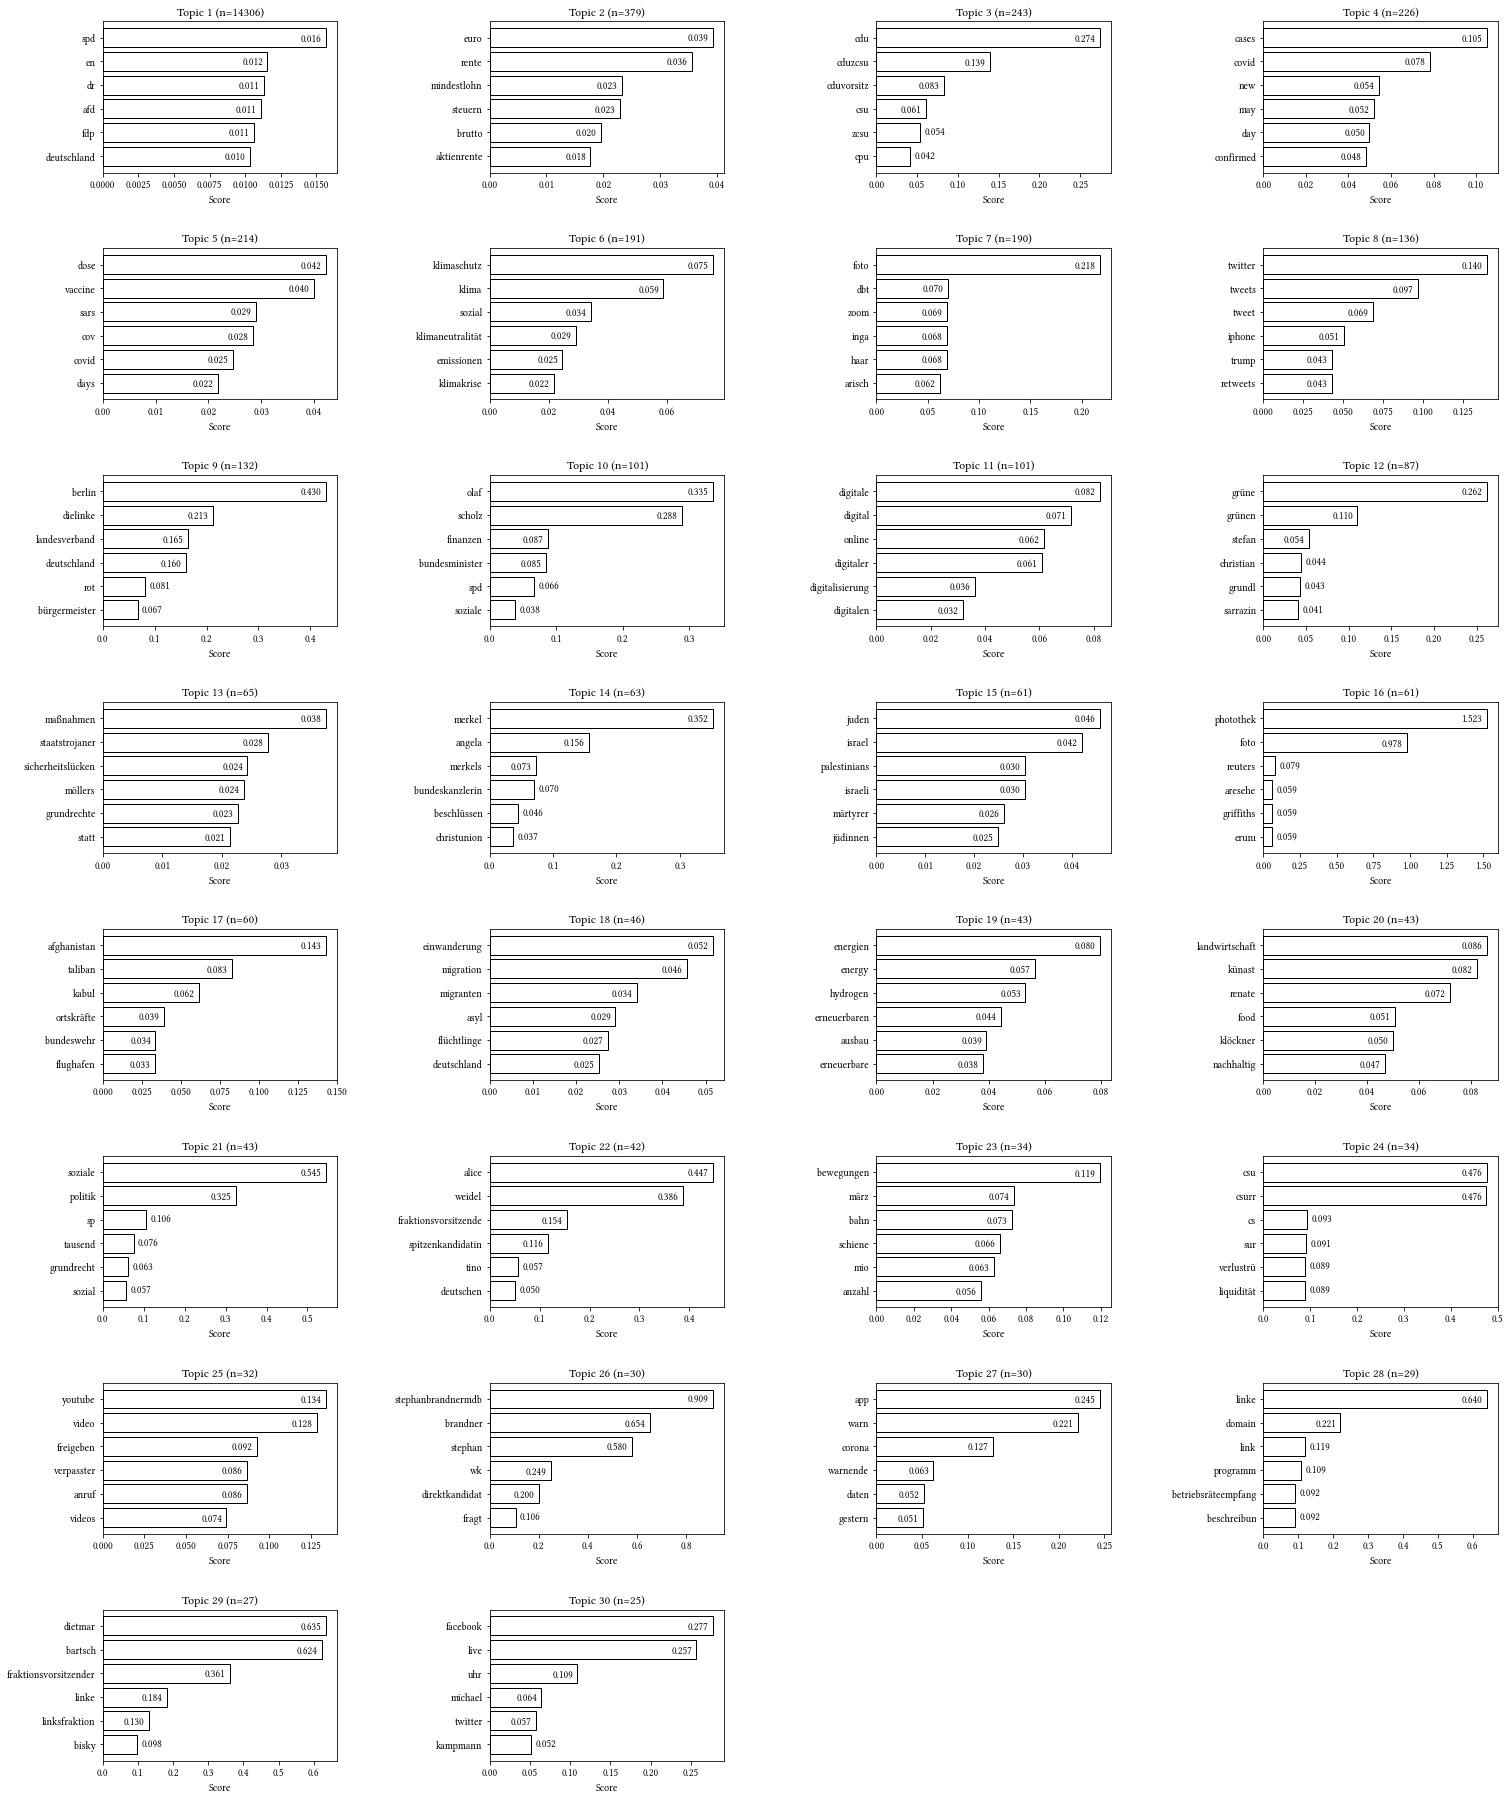

In [27]:
plot_topic_subplots(df_topics, n_topics, document_info["Topic"].value_counts(), filename="plots/top5_topics")

A ward linkage function is used to perform the hierarchical clustering based on the cosine distance matrix between topic embeddings.

In [28]:
fig = model.visualize_hierarchy(width=2000, height=2000)
fig.write_html("plots/hirachy.html")

Visualize a heatmap of the topic's similarity matrix. Based on the cosine similarity matrix between topic embeddings, a heatmap is created showing the similarity between topics.

In [29]:
fig = model.visualize_heatmap(width=2000, height=2000)#(cleaned_text)
fig.write_html("plots/heatmap.html")

### Topics over time

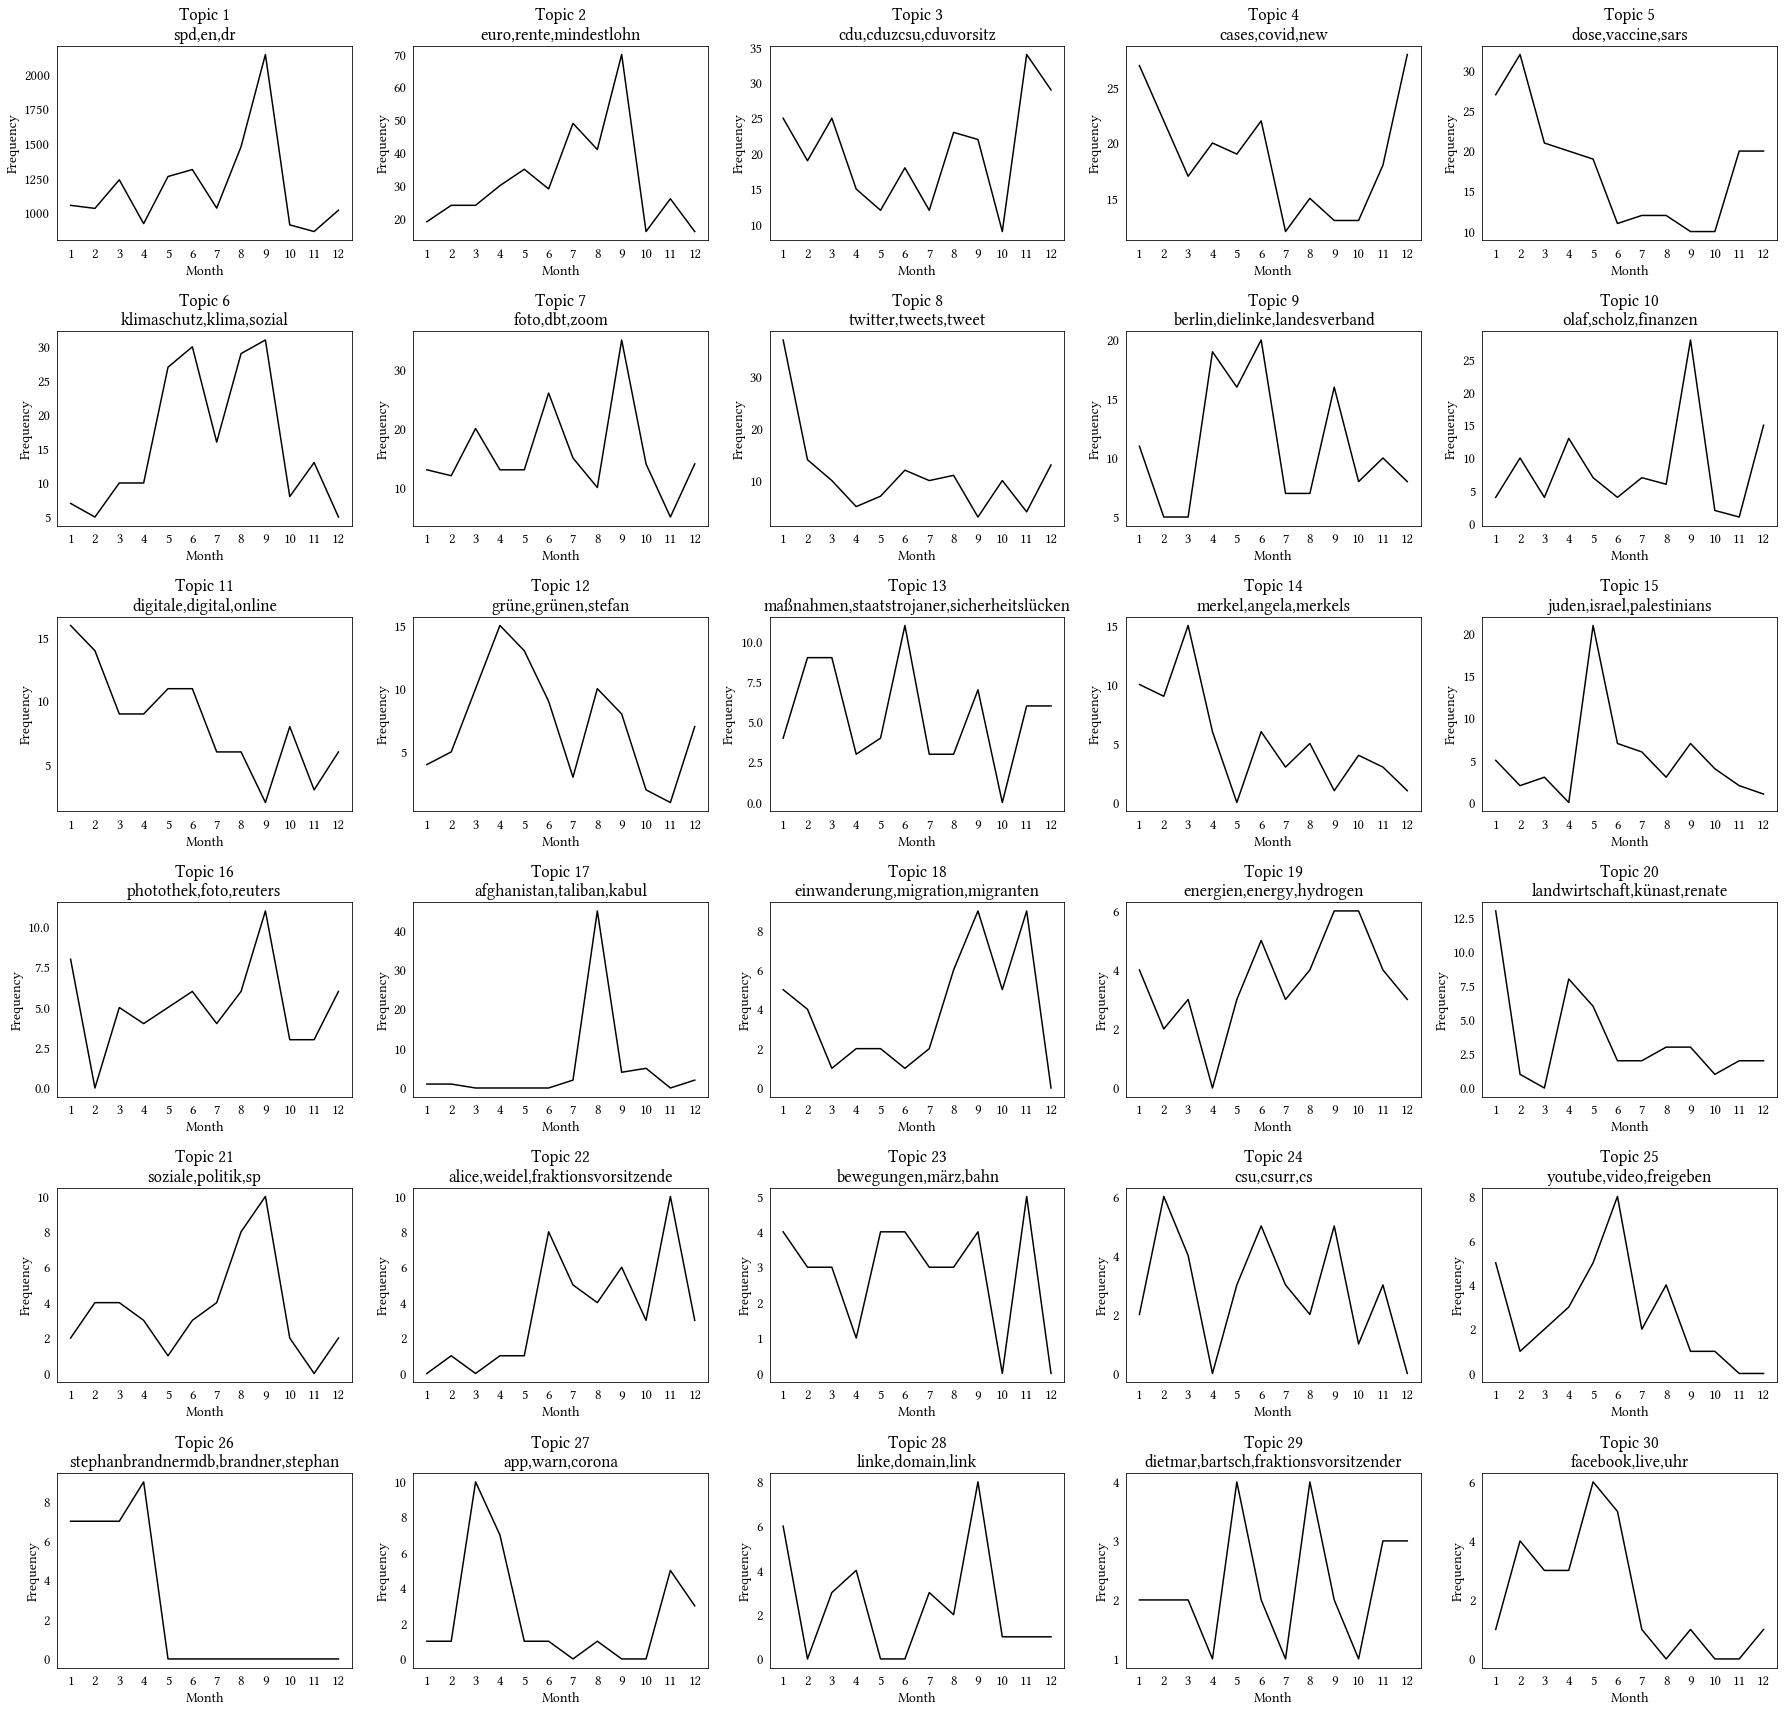

In [30]:
plot_timeseries_subplots(df_topics, n_topics, topics_over_time, filename="plots/timeseries_topics")

#### Sentiment Over Time

In [31]:
if 'sentiment' in df.columns:
     plot_timeseries_sentiment_subplots(df_topics, n_topics, document_info, topics_over_time, filename="plots/timeseries_sentiment_subplots")